In [1]:
# Reload and changes to module without having to restart kernel.
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import loneliness.psm as psm

import scipy.stats

### Load features

In [4]:
features = pd.read_csv("features.csv", index_col='pcstrip')
# features = pd.read_csv("features_all_jgi.csv", index_col='pcstrip')

feature_vars = ['ru_rank',
                'A1', 'B1', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2',
                'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
                'index_multiple_deprivation',
                'gp0_9', 'gp10_24', 'gp25_49', 'gp50_79', 'gp80p',
                'tot_patients',
                'gp_norm_gp0_9', 'gp_norm_gp10_24', 'gp_norm_gp25_49', 'gp_norm_gp50_79', 'gp_norm_gp80p',
                'nearby_schools', 'nearby_schools_zscore',
                'Academy', 'College', 'IndependentSchool', 'MaintainedSchool', 'SpecialSchool',
                'norm_in_0_9', 'norm_in_10_24', 'norm_in_25_49', 'norm_in_50_79', 'norm_in_80p',
                'norm_out_0_9', 'norm_out_10_24', 'norm_out_25_49', 'norm_out_50_79', 'norm_out_80p',
                'in_0_9', 'in_10_24', 'in_25_49', 'in_50_79', 'in_80p',
                'out_0_9', 'out_10_24', 'out_25_49', 'out_50_79', 'out_80p',
                'moves_in_zscore', 'moves_out_zscore']


feature_vars_all = ['ru_rank', 'moves_in_zscore',
                'gp_norm_gp0_9', 'gp_norm_gp10_24', 'gp_norm_gp25_49',
                'gp_norm_gp50_79', 'gp_norm_gp80p', 'index_multiple_deprivation', 'nearby_schools_zscore']

### Difference in means: outcome variable

We look at the differnece in loneliness mean when we split GP's based on the number of schools nearby.

For real-valued variables, we have to create a boolean treatment variable.

In [57]:
treatment = 'nearby_schools_zscore'
feature_vars = feature_vars_all[:]
feature_vars.remove(treatment)

tv = psm.create_treatment_variable(features[treatment], criteria='median')

features[tv.name] = tv

psm.naive_mean_difference(features.target, tv)

Created boolean feature 'nearby_schools_zscore_bool_median'. 
Feature distribution: [3255 3239]

target mean (g0): 1.0732601305049854
target mean (g1): 0.43261922417504356
mean difference:  -0.6406409063299419

statistic: 11.131092097357495
pval: 1.7034287238733208e-28


'Significant'

### Propensity score calculation

In [58]:
from sklearn.linear_model import LogisticRegression

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

clf_nn = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,50,), learning_rate='adaptive', max_iter=200)
clf_lr = LogisticRegression(solver='liblinear', penalty='l2')

features['prop_score'] = psm.get_propensity_scores(tv, features[feature_vars])

prop score accuracy:  0.8878965198644903


In [62]:
from sklearn.metrics import f1_score

f1_score(predicted_labels, tv.values)

0.34697064334790756

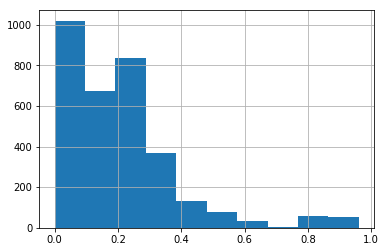

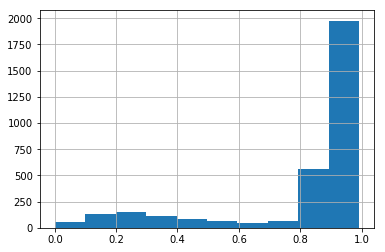

In [63]:
for (k, g) in features.groupby(tv.name):
    g.prop_score.hist()
    plt.show()

In [64]:
# psm.plot_propensity(features, feature_vars, tv)

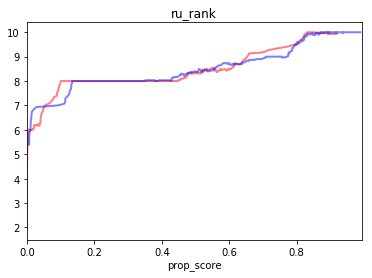

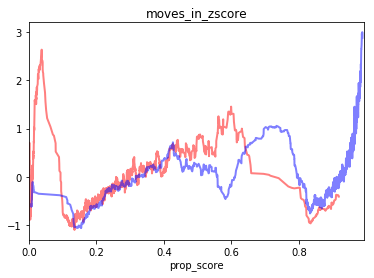

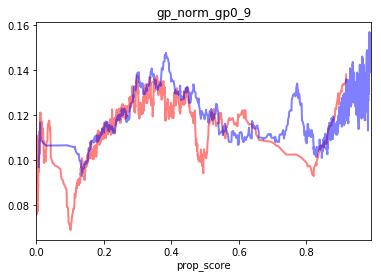

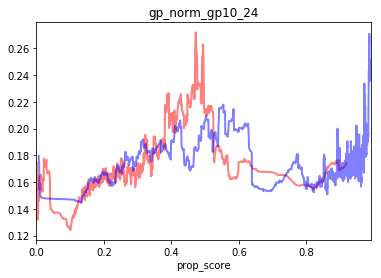

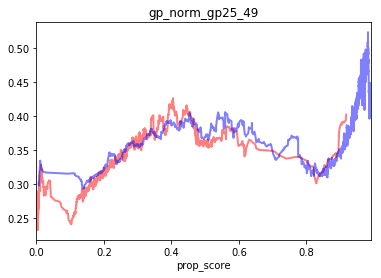

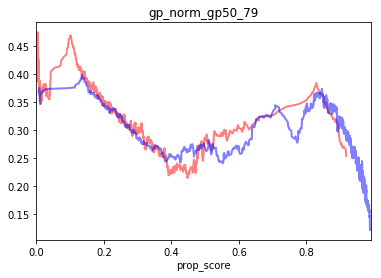

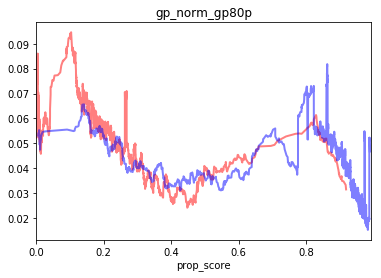

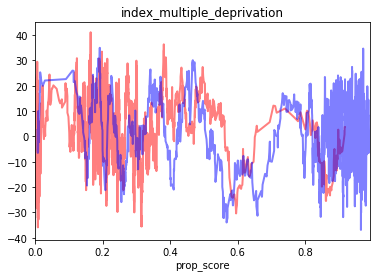

In [65]:
c = ['r', 'b']

for var in feature_vars:
    
    fig, ax = plt.subplots()
    
    for i, (k, g) in enumerate(features.groupby(tv.name)):
    #     g.plot(ax=ax, kind='scatter', x = 'prop_score', y='25-49', c = c[i], alpha=0.03)
        g[['prop_score', var]].set_index(g['prop_score'])[var].sort_index().rolling(30, center=True).mean().plot(title=var ,c=c[i], lw=2, alpha=0.5)
    
    plt.show()

In [66]:
psm.propensity_buckets(features, tv, 5)

,mean(g0),mean(g1),ttest,"|g0|, |g1|"
1,0.838233,0.694300,"(1.0424710955011143, 0.29837906223365135)","[1779, 183]"
2,1.409188,0.768806,"(3.118155368229138, 0.0019983540479610686)","[1146, 254]"
3,1.722668,1.153751,"(1.3165727158312395, 0.1890884388308077)","[191, 152]"
4,0.936168,0.842667,"(0.16600609636908376, 0.8687868946462562)","[32, 116]"
5,0.264755,0.317995,"(-0.26553345051906585, 0.7910536369376964)","[107, 2534]"


In [67]:
psm.propensity_buckets(features, tv, 5, equal_size=True)

,mean(g0),mean(g1),ttest,"|g0|, |g1|"
1,0.802752,0.629838,"(0.6018582879901418, 0.5490587299702321)","[1226, 73]"
2,1.112687,0.826467,"(2.269534114509349, 0.02407463690864513)","[1101, 198]"
3,1.523041,0.862529,"(3.450941221089496, 0.000590753044756445)","[831, 467]"
4,0.285837,0.714843,"(-2.0515580972676437, 0.04274109985055947)","[92, 1207]"
5,-1.544874,-0.057173,"(-1.1276705818450001, 0.32206858909170827)","[5, 1294]"


In [72]:
matches, g0, g1 = psm.propensity_match(features, tv)

In [93]:
g_0 = features.loc[matches['g0'], 'target']
g_1 = features.loc[matches['g1'], 'target']

In [97]:
res = g_1.mean() - g_0.mean()

In [105]:
print(res)
print(scipy.stats.ttest_1samp((g_1.reset_index(drop=True) - g_0.reset_index(drop=True)), 0.0))

# print(scipy.stats.ttest_ind(g0, g1, equal_var=False))

0.5354538786736435
Ttest_1sampResult(statistic=8.149113955213418, pvalue=5.181472884174367e-16)


In [16]:
def propensity_match_buckets(features, tv, n_bins=5):
    
    prop_to_bucket = np.digitize(features['prop_score'], np.linspace(0,1,n_bins+1))

    for (k, bucket) in features.groupby(prop_to_bucket):
    
    
        g0 = bucket[bucket[tv.name] == 0]
        g1 = bucket[bucket[tv.name] == 1]

        mi0 = bucket[bucket[tv.name] == 0].prop_score.min()
        mi1 = bucket[bucket[tv.name] == 1].prop_score.min()
        mi = max(mi0, mi1)

        ma0 = bucket[bucket[tv.name] == 0].prop_score.max()
        ma1 = bucket[bucket[tv.name] == 1].prop_score.max()
        ma = min(ma0, ma1)
       

        matches_g0 = g0.apply(lambda z: np.abs(z['prop_score'] - g1['prop_score']).idxmin(), axis=1).reset_index()
        matches_g0.columns = ['g0', 'g1']

        matches_g1 = g1.apply(lambda z: np.abs(z['prop_score'] - g0['prop_score']).idxmin(), axis=1).reset_index()
        matches_g1.columns = ['g1', 'g0']
        matches_g1 = matches_g1[['g0', 'g1']]


        matches = matches_g1
        
        pc_to_lonely = bucket.target.to_dict()

        a = pd.Series(matches.g0).apply(lambda z: pc_to_lonely[z])
        b = pd.Series(matches.g1).apply(lambda z: pc_to_lonely[z])
        print('mean:', (a-b).mean())
        print(scipy.stats.ttest_1samp(a-b, 0.0))

In [17]:
propensity_match_buckets(features, tv)

mean: 3.9252369448374105
Ttest_1sampResult(statistic=nan, pvalue=nan)


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean: -0.0813031160020496
Ttest_1sampResult(statistic=-1.4577036271937935, pvalue=0.1450190481112096)


In [18]:
from tqdm import tqdm_notebook as tqdm

In [19]:
from numpy.linalg import inv
from scipy.spatial import distance

# Find the distance between the matches found in PSM

In [20]:
vi = inv(np.cov(features[feature_vars].values, rowvar=0))

In [77]:
g0, g1 = features[feature_vars].groupby(tv)

In [22]:
match_dists = matches.apply(lambda z: distance.mahalanobis(features[feature_vars].loc[z['g0']], features[feature_vars].loc[z['g1']], vi), axis=1)

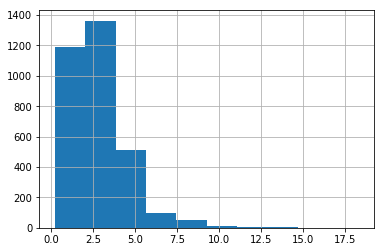

In [23]:
match_dists.hist()

# Average absolute standardized difference before matching

In [79]:
sum([np.abs(g1[1][var].mean() - g0[1][var].mean()) / features[var].std() for var in feature_vars]) / len(feature_vars)

0.6233626111410379

In [25]:
[np.abs(g0[1][var].mean() - g1[1][var].mean()) / features[var].std() for var in feature_vars]

[0.02094298289424475,
 0.0008968718353069688,
 0.04502588176685908,
 0.035532126621169925,
 0.013420057384203238,
 0.030447577274278756,
 0.05255972713594024,
 0.026529991575901905]

# Plot covariates in each group

In [26]:
features_0 = features[features[tv.name] == 0][feature_vars]

In [27]:
features_1 = features[features[tv.name] == 1][feature_vars]

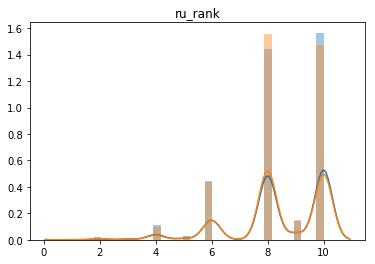

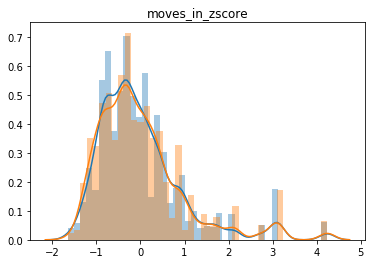

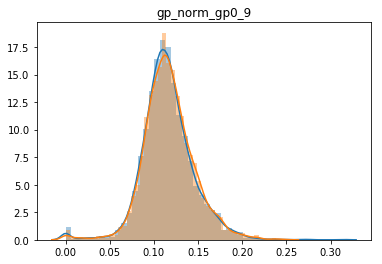

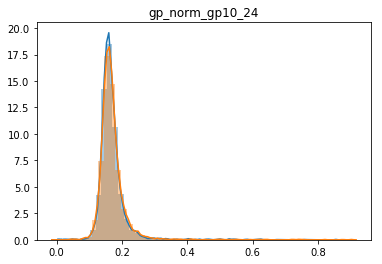

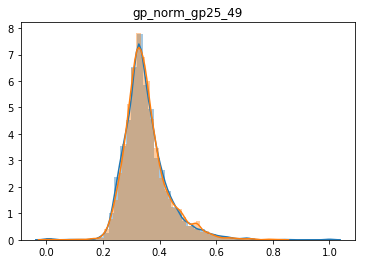

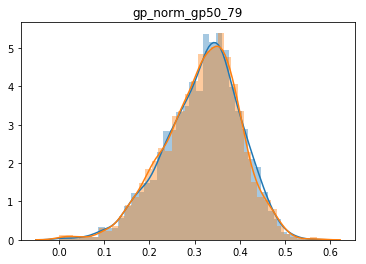

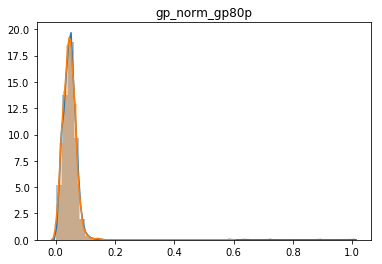

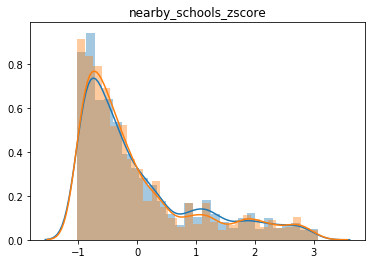

In [28]:
for v in feature_vars:
    sns.distplot(features_0[v].values)
    sns.distplot(features_1[v].values)
    plt.title(v)
    plt.show()

In [29]:
g0_matched = features.loc[matches['g0']]
g1_matched = features.loc[matches['g1']]

# Average absolute standardized difference after PSM

In [30]:
sum([np.abs(g0_matched[var].mean() - g1_matched[var].mean()) / features[var].std() for var in feature_vars]) / len(feature_vars)

0.01699172115920695

In [31]:
for var in feature_vars:
    print(var, g0_matched[var].mean(), g1_matched[var].mean(), features[var].std())
    print()

ru_rank 8.472581638940234 8.401417128773875 1.6641060305743642

moves_in_zscore 0.0002790457799438814 0.0007575693269577212 1.0006913977319367

gp_norm_gp0_9 0.11705275803070288 0.11705810428147108 0.029083177789460107

gp_norm_gp10_24 0.17291230982374356 0.17074696178735646 0.049814785511583845

gp_norm_gp25_49 0.3511341130136908 0.3510876434542031 0.0774211216010042

gp_norm_gp50_79 0.3134291233280969 0.3151286741726705 0.0835157873245491

gp_norm_gp80p 0.04547169580376526 0.04597861630429895 0.029978532676353156

nearby_schools_zscore -0.003776502003741054 -0.01494557031523036 0.9990543844841784



In [32]:
[np.abs(g0_matched[var].mean() - g1_matched[var].mean()) / features[var].std() for var in feature_vars]

[0.04276440855261858,
 0.00047819292550971423,
 0.00018382622445538516,
 0.04346797871655139,
 0.0006002181126638328,
 0.020350054750354923,
 0.016909450039012085,
 0.011179639952489679]

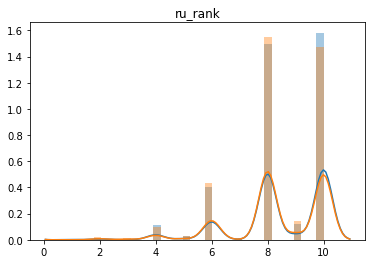

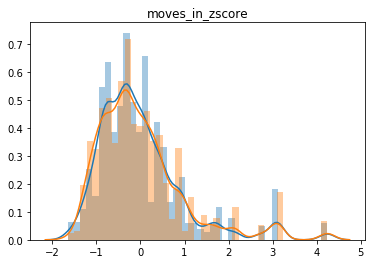

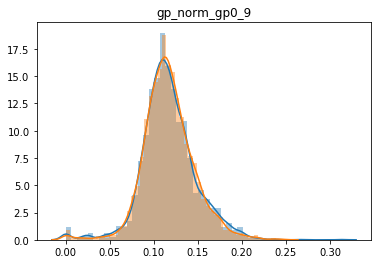

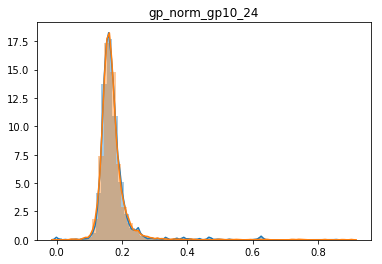

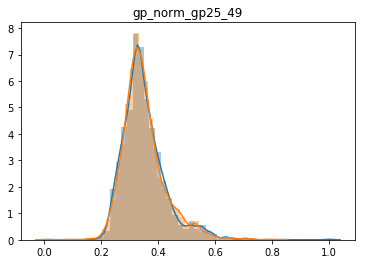

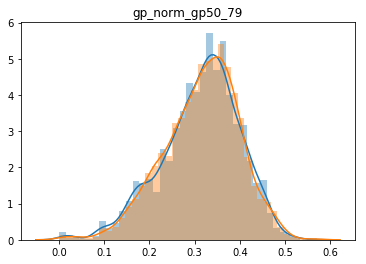

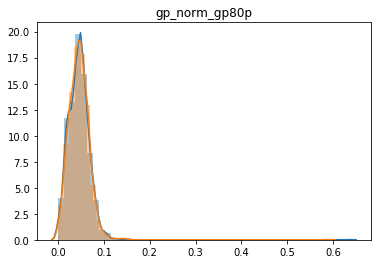

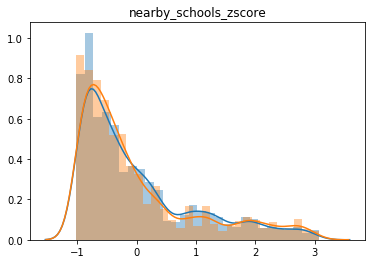

In [33]:
for v in feature_vars:
    sns.distplot(g0_matched[v].values)
    sns.distplot(g1_matched[v].values)
    plt.title(v)
    plt.show()

In [34]:
print(len(features.loc[matches['g0']]))
print(len(features.loc[matches['g0']].index.unique()))

3246
1790


# Find the nearest neighbour of a GP in group 1, in group 0

In [35]:
min_dists = {}

for a in tqdm(g1[1][feature_vars].iterrows()):
    
    min_dists[a[0]] = {'index' : -1, 'dist' : np.inf}
    
    for b in g0[1][feature_vars].iterrows():
        
        d = distance.mahalanobis(a[1].values, b[1].values, vi)
        
        if min_dists[a[0]]['dist'] > d:
            
            min_dists[a[0]]['dist'] = d
            min_dists[a[0]]['index'] = b[0]

/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


In [36]:
pd.DataFrame(min_dists).T.to_csv("min_dists.csv")

### Find the loneliness difference between matches using Nearest Neighbour

In [37]:
matches_mdm = pd.DataFrame(min_dists).T.reset_index()
matches_mdm.columns = ['g1', 'dist', 'g0']

In [38]:
matches_mdm

,g1,dist,g0
0,AL100BS,0.276709,AL100NL
1,AL108HP,0.243472,RH67DG
2,AL13HD,0.298683,SG51LH
3,AL14JE,0.499031,HU31TY
4,AL21ES,0.462928,PR11LB
5,AL23JX,0.581012,HU46RF
6,AL35ER,0.198134,B496QR
7,AL35HB,0.363723,SN251QQ
8,AL35NF,0.402274,SS93NG
9,AL35NP,0.385167,FY67PU


In [39]:
loneills_g1 = matches_mdm['g1'].apply(lambda z: features.loc[z].target)
loneills_g0 = matches_mdm['g0'].apply(lambda z: features.loc[z].target)

In [40]:
print(loneills_g1.mean())
print(loneills_g0.mean())

0.7614750096737681
0.786403883280998


In [41]:
(loneills_g0 - loneills_g1).mean()

0.024928873607229868

In [55]:
print(scipy.stats.ttest_1samp((loneills_g0 - loneills_g1), 0.0))
print(scipy.stats.ttest_ind((loneills_g0), loneills_g1))

Ttest_1sampResult(statistic=0.5208397599475508, pvalue=0.6025139398610619)
Ttest_indResult(statistic=0.44326699392630525, pvalue=0.6575874016133805)


In [43]:
print(len(features.loc[matches_mdm['g0']]))
print(len(features.loc[matches_mdm['g0']].index.unique()))

3246
1928


In [44]:
g0_matched_mdm = features.loc[matches_mdm['g0']]
g1_matched_mdm = features.loc[matches_mdm['g1']]

In [45]:
sum([np.abs(g0_matched_mdm[var].mean() - g1_matched_mdm[var].mean()) / features[var].std() for var in feature_vars]) / len(feature_vars)

0.05392389470726655

In [46]:
for var in feature_vars:
    print(var, g0_matched_mdm[var].mean(), g1_matched_mdm[var].mean(), features[var].std())
    print()

ru_rank 8.347196549599508 8.401417128773875 1.6641060305743642

moves_in_zscore -0.014162972720937944 0.0007575693269577212 1.0006913977319367

gp_norm_gp0_9 0.11491712303579917 0.11705810428147108 0.029083177789460107

gp_norm_gp10_24 0.1683766167053826 0.17074696178735646 0.049814785511583845

gp_norm_gp25_49 0.3456937803338171 0.3510876434542031 0.0774211216010042

gp_norm_gp50_79 0.32315222615049843 0.3151286741726705 0.0835157873245491

gp_norm_gp80p 0.047860253774503266 0.04597861630429895 0.029978532676353156

nearby_schools_zscore -0.0491052140534316 -0.01494557031523036 0.9990543844841784



In [47]:
[np.abs(g0_matched_mdm[var].mean() - g1_matched_mdm[var].mean()) / features[var].std() for var in feature_vars]

[0.03258240651628057,
 0.014910233146515517,
 0.07361579471029525,
 0.047583163465045375,
 0.06966914207448102,
 0.09607227848607564,
 0.06276616305802518,
 0.0341919762014139]

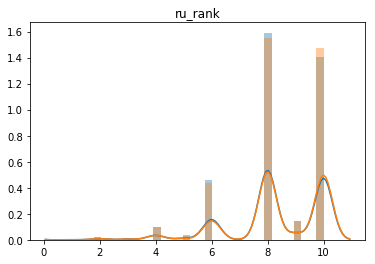

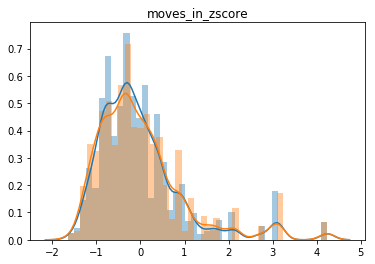

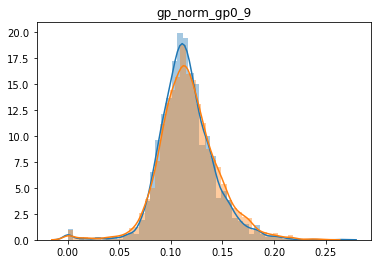

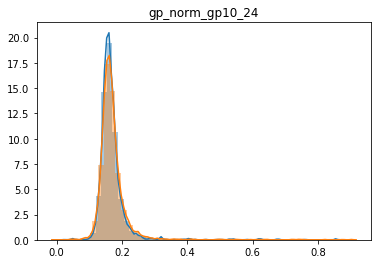

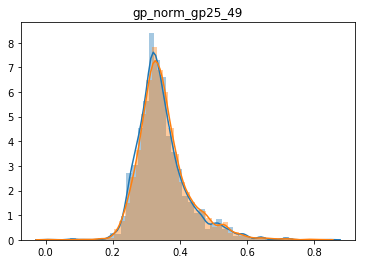

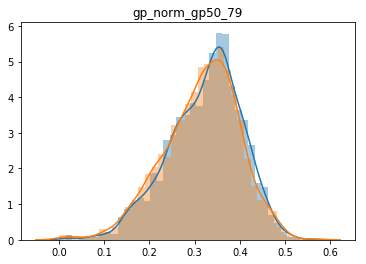

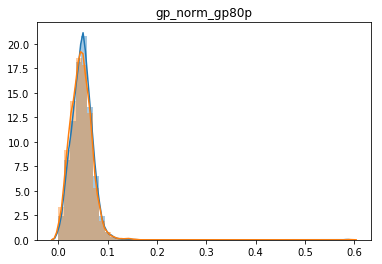

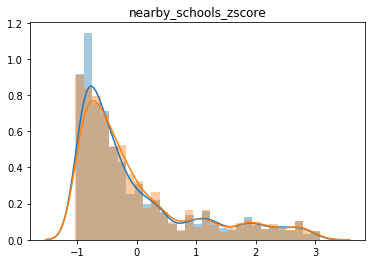

In [48]:
for v in feature_vars:
    sns.distplot(g0_matched_mdm[v].values)
    sns.distplot(g1_matched_mdm[v].values)
    plt.title(v)
    plt.show()

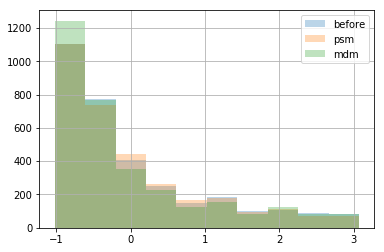

In [49]:
features[features[tv.name] == 0]['nearby_schools_zscore'].hist(alpha=0.3, label='before')
g0_matched['nearby_schools_zscore'].hist(alpha=0.3, label='psm')
g0_matched_mdm['nearby_schools_zscore'].hist(alpha=0.3, label='mdm')

plt.legend()

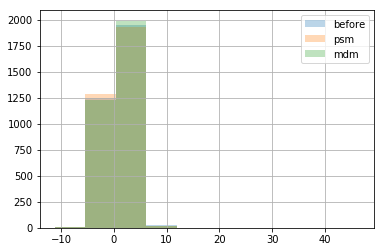

In [50]:
test = 'target'

features[features[tv.name] == 0][test].hist(alpha=0.3, label='before')
g0_matched[test].hist(alpha=0.3, label='psm')
g0_matched_mdm[test].hist(alpha=0.3, label='mdm')

plt.legend()